In [1]:
# Regression Modeling with California Housing Values 
#import packages for analysis and modeling

import pandas as pd  # data frame operations
from pandas.tools.plotting import scatter_matrix  # scatter plot matrix
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method

# read in the housing data with white-space delimiters
prelim_houses = pd.read_table('houses_data.txt', header = None, \
     delim_whitespace = True, skipinitialspace = True, \
     names = ['value', 'income', 'age', 'rooms', 'bedrooms', \
     'pop', 'hh', 'latitude', 'longitude'])
prelim_houses['idx'] = range(len(prelim_houses))  # for use as index
houses = prelim_houses.set_index(['idx']) 
     
print(houses.shape)  # check the structure of the data frame
print(houses.head())

(20640, 9)
        value  income   age   rooms  bedrooms     pop      hh  latitude  \
idx                                                                       
0    452600.0  8.3252  41.0   880.0     129.0   322.0   126.0     37.88   
1    358500.0  8.3014  21.0  7099.0    1106.0  2401.0  1138.0     37.86   
2    352100.0  7.2574  52.0  1467.0     190.0   496.0   177.0     37.85   
3    341300.0  5.6431  52.0  1274.0     235.0   558.0   219.0     37.85   
4    342200.0  3.8462  52.0  1627.0     280.0   565.0   259.0     37.85   

     longitude  
idx             
0      -122.23  
1      -122.22  
2      -122.24  
3      -122.25  
4      -122.25  


In [2]:
# SAMPLE FOR STATISTICS SUMMARY

# compute descriptive statistics for original variables
print(houses.describe())

               value        income           age         rooms      bedrooms  \
count   20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean   206855.816909      3.870671     28.639486   2635.763081    537.898014   
std    115395.615874      1.899822     12.585558   2181.615252    421.247906   
min     14999.000000      0.499900      1.000000      2.000000      1.000000   
25%    119600.000000      2.563400     18.000000   1447.750000    295.000000   
50%    179700.000000      3.534800     29.000000   2127.000000    435.000000   
75%    264725.000000      4.743250     37.000000   3148.000000    647.000000   
max    500001.000000     15.000100     52.000000  39320.000000   6445.000000   

                pop            hh      latitude     longitude  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean    1425.476744    499.539680     35.631861   -119.569704  
std     1132.462122    382.329753      2.135952      2.003532  
min        3.000000    

In [3]:
# SAMPLE FOR DATA TRANSFORMATIONS

# computed variables for linear model used by Pace and Barry (1997)
houses['log_value'] = np.log(houses['value'])
houses['income_squared'] = np.power(houses['income'], 2) 
houses['income_cubed'] = np.power(houses['income'], 3) 
houses['log_age'] = np.log(houses['age'])   
houses['log_pc_rooms'] = np.log(np.divide(houses['rooms'], houses['pop']))       
houses['log_pc_bedrooms'] = \
    np.log(np.divide(houses['bedrooms'], houses['pop']))                   
houses['log_pop_hh'] = np.divide(houses['pop'], houses['hh'])           
houses['log_hh'] = np.log(houses['hh'])   


In [4]:
# SAMPLE LINEAR MODELS

# structure of the Pace and Barry (1997) model for baseline for comparisons
pace_barry_model = 'log_value ~ income + income_squared + \
    income_cubed + log_age + log_pc_rooms + log_pc_bedrooms + \
    log_pop_hh + log_hh'

# for comparison lets look at a simple model with the original variables
simple_model = 'log_value ~ income + age + rooms + bedrooms + \
    pop + hh'

In [5]:
# SAMPLE FULL MODEL

# original variables plus variables that add value for trees 
# that is... variables that are not simple monotonic transformations
# of the original explanatory variables
full_model = 'log_value ~ income + age + rooms + bedrooms + \
  pop + hh + log_pc_rooms + log_pc_bedrooms + log_pop_hh'  
  

In [6]:
# SAMPLE SPATIAL PROCESSING

# define the bounding box for selecting the area
# here we are selecting the San Diego region
BB_TOP = 33
BB_BOTTOM = 32
BB_RIGHT = -116.75
BB_LEFT = -125

houses_selected = houses[houses['latitude'] < BB_TOP]
houses_selected = houses_selected[houses_selected['longitude'] < BB_RIGHT]
houses_selected = houses_selected[houses_selected['latitude'] > BB_BOTTOM]
houses_selected = houses_selected[houses_selected['longitude'] > BB_LEFT]

# examine structure of selected block groups
print(houses_selected.shape)
print(houses_selected.head())

(1206, 17)
          value  income   age   rooms  bedrooms    pop     hh  latitude  \
idx                                                                       
14005  441700.0  4.7396  52.0  2023.0     301.0  649.0  285.0     32.76   
14006  408500.0  5.3920  52.0  1539.0     212.0  535.0  224.0     32.75   
14007  459600.0  8.6030  52.0  1504.0     208.0  518.0  196.0     32.75   
14008  500001.0  8.1548  52.0  1495.0     230.0  459.0  190.0     32.75   
14009  411600.0  6.1309  52.0  1388.0     213.0  513.0  211.0     32.75   

       longitude  log_value  income_squared  income_cubed   log_age  \
idx                                                                   
14005    -117.18  12.998386       22.463808    106.469465  3.951244   
14006    -117.18  12.920247       29.073664    156.765196  3.951244   
14007    -117.18  13.038112       74.011609    636.721872  3.951244   
14008    -117.19  13.122365       66.500763    542.300422  3.951244   
14009    -117.19  12.927807       37.

In [7]:
# SAMPLE FOR TEST / TRAIN DATA DIVISION

# employ training-and-test regimen for model validation
np.random.seed(4444)
houses_selected['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(houses_selected))
houses_selected_train = houses_selected[houses_selected['runiform'] >= 0.33]
houses_selected_test = houses_selected[houses_selected['runiform'] < 0.33]
# check training data frame
print('\nhouses_selected_train data frame (rows, columns): ',\
    houses_selected_train.shape)
print(houses_selected_train.head())
# check test data frame
print('\nhouses_selected_test data frame (rows, columns): ',\
    houses_selected_test.shape)
print(houses_selected_test.head())


houses_selected_train data frame (rows, columns):  (793, 18)
          value  income   age   rooms  bedrooms    pop     hh  latitude  \
idx                                                                       
14005  441700.0  4.7396  52.0  2023.0     301.0  649.0  285.0     32.76   
14007  459600.0  8.6030  52.0  1504.0     208.0  518.0  196.0     32.75   
14008  500001.0  8.1548  52.0  1495.0     230.0  459.0  190.0     32.75   
14009  411600.0  6.1309  52.0  1388.0     213.0  513.0  211.0     32.75   
14010  500001.0  5.7914  52.0  1294.0     175.0  434.0  180.0     32.76   

       longitude  log_value  income_squared  income_cubed   log_age  \
idx                                                                   
14005    -117.18  12.998386       22.463808    106.469465  3.951244   
14007    -117.18  13.038112       74.011609    636.721872  3.951244   
14008    -117.19  13.122365       66.500763    542.300422  3.951244   
14009    -117.19  12.927807       37.587935    230.447870

                 log_value    income  log_pc_rooms  log_pc_bedrooms     rooms  \
log_value         1.000000  0.659510      0.675540         0.349961  0.157848   
income            0.659510  1.000000      0.527058        -0.106339  0.223225   
log_pc_rooms      0.675540  0.527058      1.000000         0.674607  0.190381   
log_pc_bedrooms   0.349961 -0.106339      0.674607         1.000000  0.027068   
rooms             0.157848  0.223225      0.190381         0.027068  1.000000   
bedrooms          0.029609 -0.025875      0.073820         0.151982  0.929458   
hh                0.020813 -0.015306      0.055065         0.108616  0.934255   
age               0.009355 -0.218314     -0.010232         0.093863 -0.371797   
pop              -0.092723  0.008507     -0.188314        -0.237542  0.897124   
log_pop_hh       -0.312509  0.021222     -0.674988        -0.860651 -0.040936   

                 bedrooms        hh       age       pop  log_pop_hh  
log_value        0.029609  0.020813  0

C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  # This is added back by InteractiveShellApp.init_path()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253631CB9E8>,
      dtype=object)

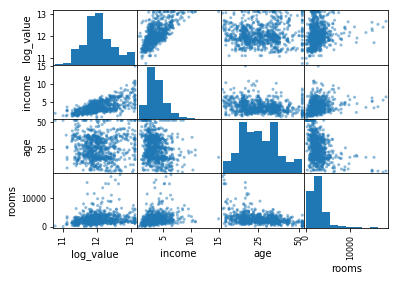

In [8]:
# SAMPLE COORELATION

# examine the correlations across the variables before we begin modeling
houses_train_df_vars = houses_selected_train.loc[ : ,['log_value', 'income',\
    'log_pc_rooms', 'log_pc_bedrooms', 'rooms', 'bedrooms', 'hh', \
    'age', 'pop', 'log_pop_hh']]
print(houses_train_df_vars.corr())
    
# OLD SCATTER PLOT DEPRACATED

    # scatter plot matrix (splom) demonstration
houses_train_splom_vars = \
    houses_selected_train.loc[:, ['log_value', 'income', 'age', 'rooms']]
scatter_matrix(houses_train_splom_vars)   

In [9]:
# --------------------------------------------
# Linear regression a la Pace and Barry (1997)
# --------------------------------------------
# fit the model to the training set
pace_barry_train_fit = smf.ols(pace_barry_model, \
    data = houses_selected_train).fit()
# summary of model fit to the training set
print(pace_barry_train_fit.summary())
# training set predictions from the model fit to the training set
houses_selected_train['predict_log_value'] = pace_barry_train_fit.fittedvalues
# test set predictions from the model fit to the training set
houses_selected_test['predict_log_value'] = pace_barry_train_fit.predict(houses_selected_test)

# compute the proportion of response variance for training data
pace_and_barry_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['predict_log_value']),2),3)
print('\nPace and Barry Proportion of Training Set Variance Accounted for: ',\
    pace_and_barry_train_result)

# compute the proportion of response variance
# accounted for when predicting out-of-sample
pace_and_barry_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['predict_log_value']),2),3)
print('\nPace and Barry Proportion of Test Set Variance Accounted for: ',\
    pace_and_barry_test_result)

                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     176.8
Date:                Sun, 07 Oct 2018   Prob (F-statistic):          7.51e-170
Time:                        18:20:45   Log-Likelihood:                -62.370
No. Observations:                 793   AIC:                             142.7
Df Residuals:                     784   BIC:                             184.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.3731      0.154     

C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# --------------------------------------
# Tree-structured regression
# --------------------------------------

tree_model_maker = DecisionTreeRegressor(random_state = 9999, max_depth = 5)

y_train = houses_selected_train.loc[:, ['log_value']]

# simple model has six predictors
X_train_simple = houses_selected_train.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]
X_test_simple = houses_selected_test.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]

tree_model_fit = tree_model_maker.fit(X_train_simple, y_train)

# compute the proportion of response variance for training data
houses_selected_train['simple_tree_predict_log_value'] =\
    tree_model_fit.predict(X_train_simple)
simple_tree_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['simple_tree_predict_log_value']),2),3)
print('\nSimple Tree Proportion of Training Set Variance Accounted for: ',\
    simple_tree_train_result)

# compute the proportion of response variance for test data
houses_selected_test['simple_tree_predict_log_value'] =\
    tree_model_fit.predict(X_test_simple)
simple_tree_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['simple_tree_predict_log_value']),2),3)
print('\nSimple Tree Proportion of Test Set Variance Accounted for: ',\
    simple_tree_test_result)



Simple Tree Proportion of Training Set Variance Accounted for:  0.621

Simple Tree Proportion of Test Set Variance Accounted for:  0.461


C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# --------------------------------------
# Tree-structured regression (full)
# --------------------------------------
# same method as for simple tree
tree_model_maker = DecisionTreeRegressor(random_state = 9999, max_depth = 5)

y_train = houses_selected_train.loc[:, ['log_value']]

# full model has more predictors
X_train_full = houses_selected_train.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms',\
        'pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]
X_test_full = houses_selected_test.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms',\
        'pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]

tree_model_fit = tree_model_maker.fit(X_train_full, y_train)

# compute the proportion of response variance for training data
houses_selected_train['full_tree_predict_log_value'] =\
    tree_model_fit.predict(X_train_full)
full_tree_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['full_tree_predict_log_value']),2),3)
print('\nFull Tree Proportion of Training Set Variance Accounted for: ',\
    full_tree_train_result)

# compute the proportion of response variance for test data
houses_selected_test['full_tree_predict_log_value'] =\
    tree_model_fit.predict(X_test_full)
full_tree_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['full_tree_predict_log_value']),2),3)
print('\nFull Tree Proportion of Test Set Variance Accounted for: ',\
    full_tree_test_result)



Full Tree Proportion of Training Set Variance Accounted for:  0.729

Full Tree Proportion of Test Set Variance Accounted for:  0.612


C:\Users\datab\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\datab\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
# --------------------------------------
# Random forest
# --------------------------------------
rf_model_maker = RandomForestRegressor(random_state = 9999)

y_train = houses_selected_train.loc[:, ['log_value']]

# simple model has more predictors
X_train_simple = houses_selected_train.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]
X_test_simple = houses_selected_test.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]

rf_model_fit = rf_model_maker.fit(X_train_simple, y_train)

# compute the proportion of response variance for training data
houses_selected_train['simple_rf_predict_log_value'] =\
    rf_model_fit.predict(X_train_simple)
simple_rf_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['simple_rf_predict_log_value']),2),3)
print('\nSimple Random Forest Prop Training Set Variance Accounted for: ',\
    simple_rf_train_result)

# compute the proportion of response variance for test data
houses_selected_test['simple_rf_predict_log_value'] =\
    rf_model_fit.predict(X_test_simple)
simple_rf_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['simple_rf_predict_log_value']),2),3)
print('\nSimple Random Forest Prop of Test Set Variance Accounted for: ',\
    simple_rf_test_result)


C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':



Simple Random Forest Prop Training Set Variance Accounted for:  0.939

Simple Random Forest Prop of Test Set Variance Accounted for:  0.589


C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# --------------------------------------
# Random forests (full)
# --------------------------------------
rf_model_maker = RandomForestRegressor(random_state = 9999)

y_train = houses_selected_train.loc[:, ['log_value']]

# full model has more predictors
X_train_full = houses_selected_train.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms',\
        'pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]
X_test_full = houses_selected_test.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms',\
        'pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]

rf_model_fit = rf_model_maker.fit(X_train_full, y_train)

# compute the proportion of response variance for training data
houses_selected_train['full_rf_predict_log_value'] =\
    rf_model_fit.predict(X_train_full)
full_rf_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['full_rf_predict_log_value']),2),3)
print('\nFull Random Forest Prop of Training Set Variance Accounted for: ',\
    full_rf_train_result)

# compute the proportion of response variance for test data
houses_selected_test['full_rf_predict_log_value'] =\
    rf_model_fit.predict(X_test_full)
full_rf_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['full_rf_predict_log_value']),2),3)
print('\nFull Random Forest Prop of Test Set Variance Accounted for: ',\
    full_rf_test_result)

C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':



Full Random Forest Prop of Training Set Variance Accounted for:  0.946

Full Random Forest Prop of Test Set Variance Accounted for:  0.627


C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Bhavani Shankar\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
